# Работа по теме "Численное прогнозирование"

## Описание

Работа предполагает самостоятельное исследование данных и построение регрессионных моделей.

Основная задача работы - научиться работать с методами численного прогнозирования, настраивать и отбирать лучшие модели.

Предлагается один набор данных.

Примерные критерии оценки:
- представленные данные изучены и описаны;
- данные предобработаны при необходимости, разделены на выборки;
- верно проведена обработка категориальных данных;
- рассмотрено не менее трех различных методов регрессии;
- создаваемые модели настроены для получения наилучших результатов;
- рассмотрены различные метрики для оценки, при описании результатов метрики верно интерпретированы.

В результате необходимо получить наилучшую модель численного прогнозирования, при этом основную метрику разрешается выбрать самостоятельно, объяснив свой выбор. Также должен быть показан весь процесс выбора и настройки моделей.

## Импорт библиотек

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Анализ доходов домохозяйств

Набор данных `household_income.csv`.

Описание данных:
- Age: Age of the primary household member (18 to 70 years).
- Education Level: Highest education level attained (High School, Bachelor's, Master's, Doctorate).
- Occupation: Type of occupation (Healthcare, Education, Technology, Finance, Others).
- Number of Dependents: Number of dependents in the household (0 to 5).
- Location: Residential location (Urban, Suburban, Rural).
- Work Experience: Years of work experience (0 to 50 years).
- Marital Status: Marital status of the primary household member (Single, Married, Divorced).
- Employment Status: Employment status of the primary household member (Full-time, Part-time, Self-employed).
- Household Size: Total number of individuals living in the household (1 to 7).
- Homeownership Status: Homeownership status (Own, Rent).
- Type of Housing: Type of housing (Apartment, Single-family home, Townhouse).
- Gender: Gender of the primary household member (Male, Female).
- Primary Mode of Transportation: Primary mode of transportation used by the household member
(Car, Public transit, Biking, Walking).
- Income: Actual annual household income, derived from a combination of features
with added noise. Unit USD

Целевая переменная - Income.

Требуется построить наилучшую модель для прогнозирования доходов домохозяйств.

### Загрузка и изучение данных

In [200]:
data = pd.read_csv("household_income.csv")
print(data.head())
print(data.info())
print(data.describe())
print(data.nunique())

   Age Education_Level  Occupation  Number_of_Dependents Location  \
0   56        Master's  Technology                     5    Urban   
1   69     High School     Finance                     0    Urban   
2   46      Bachelor's  Technology                     1    Urban   
3   32     High School      Others                     2    Urban   
4   60      Bachelor's     Finance                     3    Urban   

   Work_Experience Marital_Status Employment_Status  Household_Size  \
0               21        Married         Full-time               7   
1                4         Single         Full-time               7   
2                1         Single         Full-time               7   
3               32        Married         Full-time               1   
4               15        Married     Self-employed               4   

  Homeownership_Status     Type_of_Housing  Gender  \
0                  Own           Apartment    Male   
1                  Own           Apartment    Male

In [201]:
data.isnull().sum()

Age                               0
Education_Level                   0
Occupation                        0
Number_of_Dependents              0
Location                          0
Work_Experience                   0
Marital_Status                    0
Employment_Status                 0
Household_Size                    0
Homeownership_Status              0
Type_of_Housing                   0
Gender                            0
Primary_Mode_of_Transportation    0
Income                            0
dtype: int64

In [202]:
print("Размер данных:", data.shape)

Размер данных: (10000, 14)


### Распределение целевой переменной

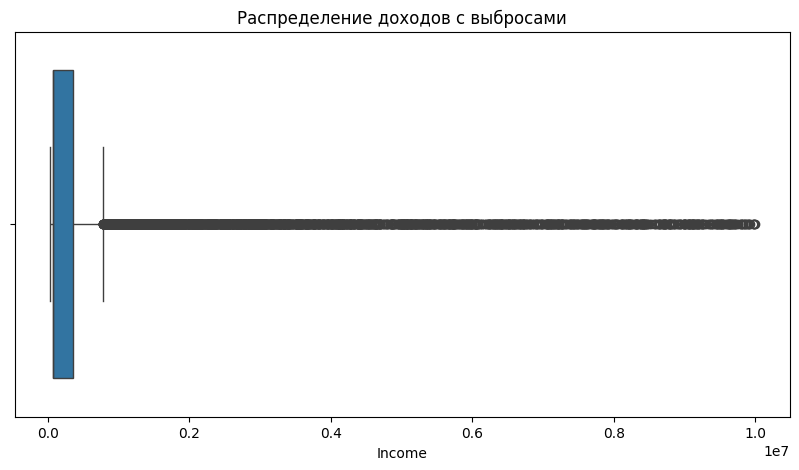

In [203]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['Income'])
plt.title('Распределение доходов с выбросами')
plt.show()

### Предобработка данных

### Создание пайплайнов для моделей

In [204]:
# Преобразование категориальных и числовых признаков
categorical_features = [
    "Education_Level", "Occupation", "Location", "Marital_Status",
    "Employment_Status", "Homeownership_Status", "Type_of_Housing", 
    "Gender", "Primary_Mode_of_Transportation"
]
# "Age",
numerical_features = [
     "Work_Experience", "Number_of_Dependents", "Household_Size"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)
# Модели
models = {
    "Linear Regression": Pipeline([("preprocessor", preprocessor), ("model", LinearRegression())]),
    "Random Forest": Pipeline([("preprocessor", preprocessor), ("model", RandomForestRegressor(random_state=42))]),
    "XGBoost": Pipeline([("preprocessor", preprocessor), ("model", XGBRegressor(random_state=42))])
}

### Проверка мультиколлинеарности:

In [205]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Feature"] = numerical_features
vif["VIF"] = [variance_inflation_factor(data[numerical_features].values, i) for i in range(len(numerical_features))]
print(vif)

                Feature       VIF
0       Work_Experience  2.775552
1  Number_of_Dependents  2.470361
2        Household_Size  2.993300


Удалить признак Age (VIF > 5)

### Обработка выбросов:

In [206]:
# Удаление выбросов через IQR
Q1 = data['Income'].quantile(0.25)
Q3 = data['Income'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['Income'] >= Q1 - 1.5*IQR) & (data['Income'] <= Q3 + 1.5*IQR)]

In [207]:
# Логарифмирование целевой переменной
data["Income_log"] = np.log(data["Income"] + 1)
y = data["Income_log"]

Q1 = data['Income_log'].quantile(0.05)  # Используем 5-й перцентиль для более мягкого обрезания
Q3 = data['Income_log'].quantile(0.95)
data_clean = data[(data['Income_log'] >= Q1) & (data['Income_log'] <= Q3)]

#### Добавим новые признаки: взаимодействие опыта работы и уровня образования

In [208]:
data["Work_Experience_x_Education"] = data["Work_Experience"] * data["Education_Level"].map({
    "High School": 1,
    "Bachelor's": 2,
    "Master's": 3,
    "Doctorate": 4
})

### Проверим влияние обработки выбросов:

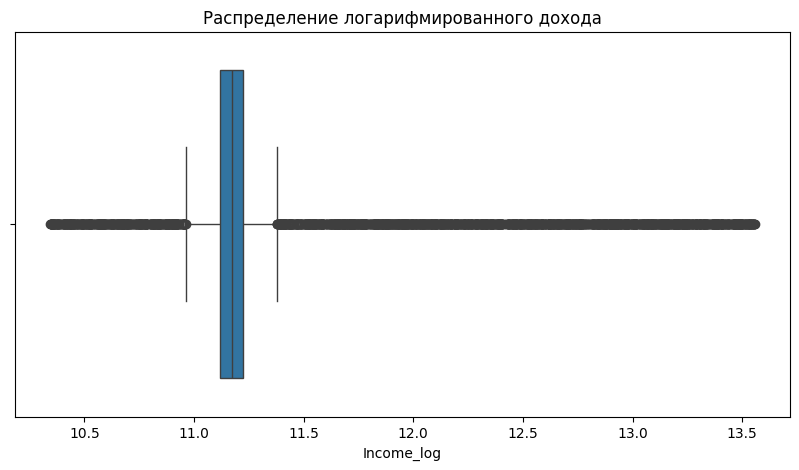

In [209]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=data["Income_log"])
plt.title("Распределение логарифмированного дохода")
plt.show()

In [210]:
X = data_clean.drop(["Income", "Income_log", "Age"], axis=1)
y = data_clean["Income_log"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [211]:
data = data.dropna()

# for col in categorical_features:
#     data[col] = data[col].astype("str")

assert set(X_train.columns) == set(categorical_features + numerical_features), "Столбцы не совпадают"

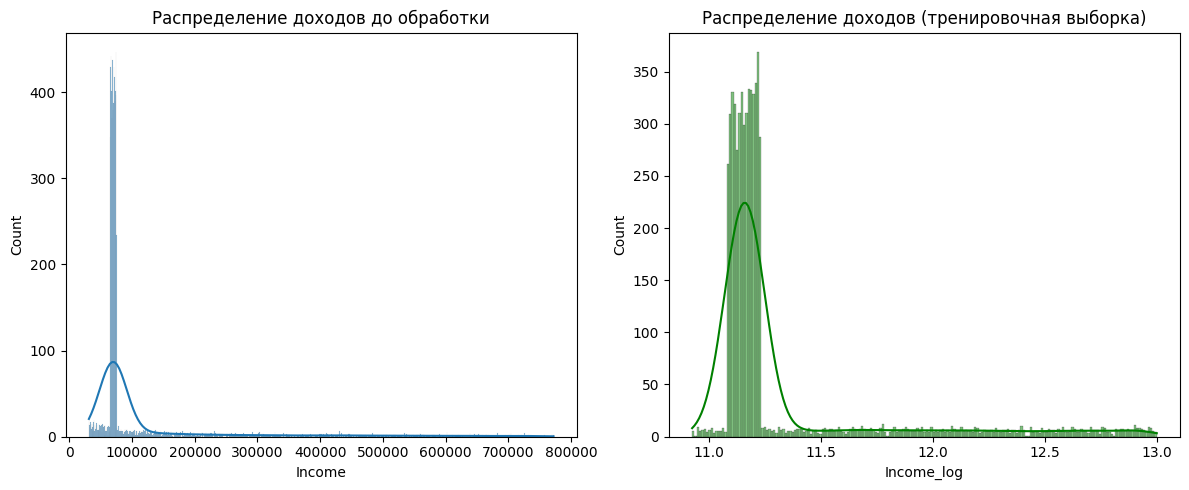

In [212]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['Income'], kde=True)
plt.title('Распределение доходов до обработки')

plt.subplot(1, 2, 2)
sns.histplot(y_train, kde=True, color='green')
plt.title('Распределение доходов (тренировочная выборка)')
plt.tight_layout()
plt.show()

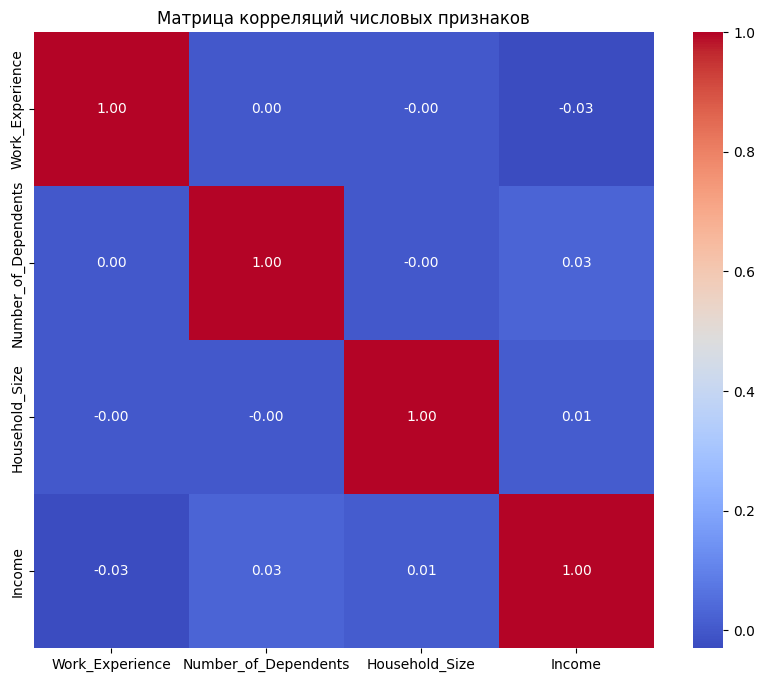

In [213]:
num_data = data[numerical_features + ['Income']]
plt.figure(figsize=(10, 8))
sns.heatmap(num_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций числовых признаков')
plt.show()

### Обучение и настройка моделей
#### Пример для Random Forest:

In [214]:
param_grid_rf = {
    "model__n_estimators": [200, 300],
    "model__max_depth": [10, 15, None],
    "model__min_samples_split": [2, 5]
}

grid_search_rf = GridSearchCV(
    models["Random Forest"], 
    param_grid_rf, 
    cv=5, 
    scoring="r2",
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)
print("Лучшие параметры:", grid_search_rf.best_params_)

Лучшие параметры: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 300}


#### Для XGBoost:

In [215]:
param_grid_xgb = {
    "model__max_depth": [3, 5, 7],                # Уменьшаем глубину
    "model__n_estimators": [300, 500],            # Больше деревьев
    "model__learning_rate": [0.005, 0.01, 0.05],  # Меньше шаг
    "model__subsample": [0.7, 0.8],               # Борьба с переобучением
    "model__colsample_bytree": [0.7, 0.9],        # Случайный выбор признаков
    "model__gamma": [0, 0.1],                     # Минимальное снижение потерь
    "model__reg_lambda": [1, 5]                   # L2-регуляризация
}

grid_search_xgb = GridSearchCV(
    models["XGBoost"], 
    param_grid_xgb, 
    cv=5, 
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)
print("Лучшие параметры:", grid_search_xgb.best_params_)

Лучшие параметры: {'model__colsample_bytree': 0.9, 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 500, 'model__reg_lambda': 5, 'model__subsample': 0.8}


#### Использование кросс-валидации с увеличенным количеством фолдов

In [216]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    grid_search_xgb.best_estimator_, 
    X_train, 
    y_train, 
    cv=10, 
    scoring="r2"
)
print("Средний R² на кросс-валидации:", scores.mean())

Средний R² на кросс-валидации: 0.16607696721585766


#### Применение SMOTE для балансировки данных

In [217]:
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

# 1. Сброс индексов
X_train = X_train.reset_index(drop=True)
data = data.reset_index(drop=True)

# 2. Создание бинов для целевой переменной
data["Income_bin"] = pd.qcut(data["Income_log"], q=5, labels=False)
y_balanced_target = data.loc[X_train.index, "Income_bin"].reset_index(drop=True)

# 3. Кодирование категориальных признаков
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())

# 4. Применение SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train_encoded, y_balanced_target)

# 5. Исправление параметров XGBoost
best_params = {k.replace("model__", ""): v for k, v in grid_search_xgb.best_params_.items()}
model_xgb_balanced = XGBRegressor(**best_params)
model_xgb_balanced.fit(X_balanced, y_balanced)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

### Использование Optuna для автоматической оптимизации

In [218]:
import optuna
from sklearn.model_selection import cross_val_score

# Преобразуйте данные в числовые
X_train_encoded = pd.get_dummies(X_train)

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0)
    }
    model = XGBRegressor(**params)
    score = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring="r2").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Лучшие параметры:", study.best_params)

[I 2025-04-30 22:03:46,130] A new study created in memory with name: no-name-1ce77a7b-a49c-4e48-9e0d-daa2b215df57
[I 2025-04-30 22:03:47,783] Trial 0 finished with value: 0.09692552645277006 and parameters: {'max_depth': 4, 'n_estimators': 648, 'learning_rate': 0.0027931569650809815, 'subsample': 0.6267894545082808, 'reg_lambda': 2.371204163506839}. Best is trial 0 with value: 0.09692552645277006.
[I 2025-04-30 22:03:51,344] Trial 1 finished with value: 0.163804708846927 and parameters: {'max_depth': 8, 'n_estimators': 597, 'learning_rate': 0.004443931369180816, 'subsample': 0.9744787194342007, 'reg_lambda': 5.4558731727279}. Best is trial 1 with value: 0.163804708846927.
[I 2025-04-30 22:03:56,539] Trial 2 finished with value: 0.19783413492337146 and parameters: {'max_depth': 10, 'n_estimators': 570, 'learning_rate': 0.0037551475812124696, 'subsample': 0.9244817731331019, 'reg_lambda': 6.060399604183332}. Best is trial 2 with value: 0.19783413492337146.
[I 2025-04-30 22:04:09,456] Tri

Лучшие параметры: {'max_depth': 10, 'n_estimators': 447, 'learning_rate': 0.008610115398412728, 'subsample': 0.850249139332045, 'reg_lambda': 6.500550653695055}


### Ансамбли моделей

In [219]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ("xgb", XGBRegressor(max_depth=5, n_estimators=300)),
    ("rf", RandomForestRegressor(n_estimators=200, max_depth=10))
]
stack_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stack_model.fit(X_train_encoded, y_train)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constra...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('rf',
                               RandomForestRegressor(max_depth=10,
                                                     n_estimators=200))],
                  final_estimator=LinearRegression())

### Применение PCA для уменьшения размерности

In [220]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

# Определение категориальных и числовых признаков
categorical_features = [
    "Education_Level", "Occupation", "Location", "Marital_Status",
    "Employment_Status", "Homeownership_Status", "Type_of_Housing", 
    "Gender", "Primary_Mode_of_Transportation"
]

numerical_features = [
    "Work_Experience", "Number_of_Dependents", "Household_Size"
]

# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)

# PCA применяется только к преобразованным данным
pca_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=0.95))  # Сохраняем 95% дисперсии
])

# Итоговая модель
model_pca = Pipeline([
    ("pca_pipeline", pca_pipeline),
    ("model", XGBRegressor(random_state=42))
])

# Обучение модели
model_pca.fit(X_train, y_train)

Pipeline(steps=[('pca_pipeline',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['Education_Level',
                                                                    'Occupation',
                                                                    'Location',
                                                                    'Marital_Status',
                                                                    'Employment_Status',
                                                                    'Homeownership_Status',
                                                                    'Type_of_Housing',
                                                                    'Gender',
                                                                    'Primary_Mode_of_Transportation']),
                                                                  ('num',
                                                                   StandardScaler(),
                                                                   ['Work_Experience',...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

### Оценка моделей

In [221]:
models = {
    "XGBoost (tuned)": grid_search_xgb.best_estimator_,
    "Random Forest (tuned)": grid_search_rf.best_estimator_,
    "XGBoost + PCA": model_pca
}

metrics = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    metrics[name] = {
        "MAE": mean_absolute_error(np.exp(y_test), np.exp(y_pred)),  # Возвращаем исходный масштаб
        "RMSE": np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred))),
        "R2": r2_score(np.exp(y_test), np.exp(y_pred))
    }

results = pd.DataFrame(metrics).T
print(results)

                                MAE          RMSE        R2
XGBoost (tuned)        28652.358267  64066.122921  0.114731
Random Forest (tuned)  27974.960161  60378.875350  0.213700
XGBoost + PCA          31476.124607  66501.264778  0.046154


### Визуализация результатов

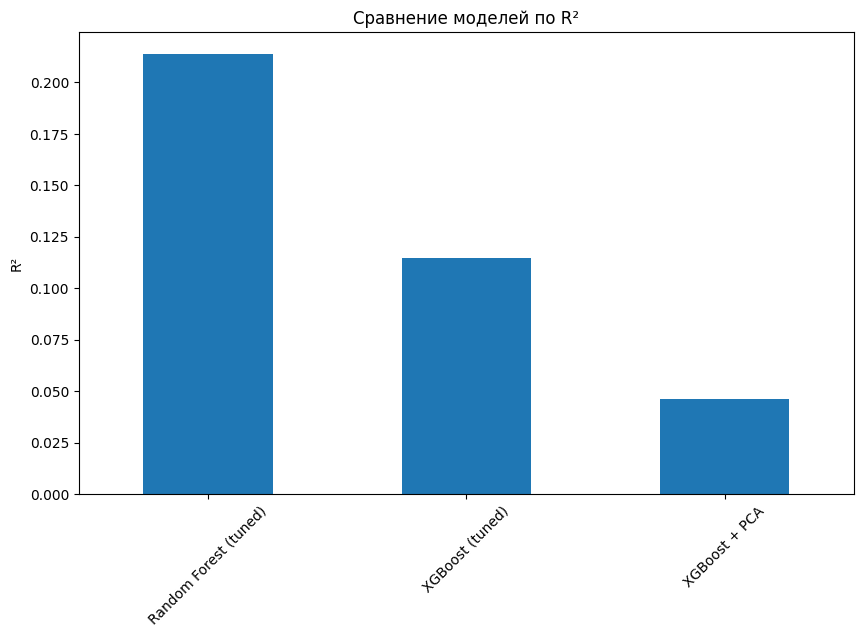

In [222]:
plt.figure(figsize=(10, 6))
results.sort_values("R2", ascending=False)["R2"].plot(kind="bar")
plt.title("Сравнение моделей по R²")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.show()

### Анализ важности признаков

Количество важностей признаков: 32
Количество имен признаков: 32


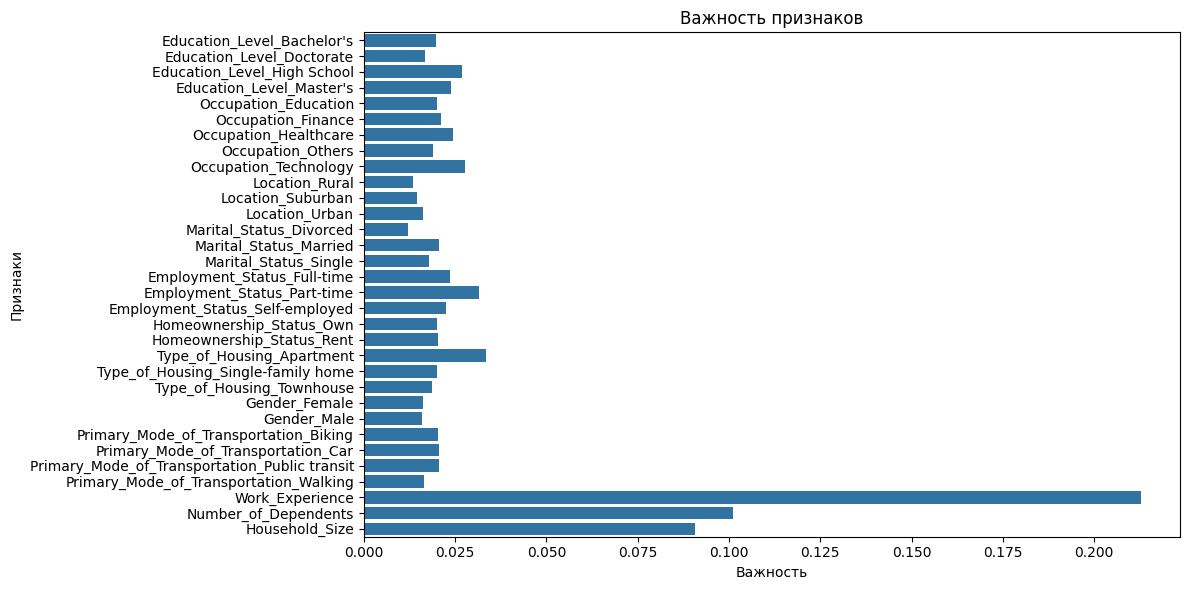

In [223]:
# Важность признаков из лучшей модели
feature_importances = grid_search_rf.best_estimator_.named_steps["model"].feature_importances_

# Все имена признаков после преобразования
all_features = preprocessor.get_feature_names_out()
all_features = [f.split("__")[-1] for f in all_features]  # Убираем префиксы

# Проверка размеров
print("Количество важностей признаков:", len(feature_importances))
print("Количество имен признаков:", len(all_features))

# Постройте график
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances, y=all_features)
plt.title("Важность признаков")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

# Выводы

Ключевые выводы по задачам.

Изначально без очистки выбросов и  результат метрик был:
```                            MAE          RMSE        R2
Linear Regression  1.102166e+06  1.770979e+06  0.005862
Random Forest      1.150720e+06  1.761470e+06  0.016510
XGBoost            1.231355e+06  1.900536e+06 -0.144912
```

Средние ошибки всех метрик просто огромны, в то же время эффективность метрик (R2) крайне низка. Это означает, что модели практически не объясняют вариативность доходов.
У XGBoost R2 вообще отрицательна, что хуже, чем предсказание среднего значения.
Проблемы данных:
- Выбросы в доходе: На графике распределения видно, что значения `Income` достигают 1e7, что искажает метрики (MAE, RMSE).

- Мультиколлинеарность: Признаки `Age` (VIF=5.14) и `Household_Size` (VIF=3.91) имеют высокую корреляцию с другими переменными.

- Низкая информативность признаков: Матрица корреляций показывает слабую связь числовых признаков с целевой переменной (максимум |0.03|).

Нужна явно уменьшить количество признаков, оптимизировать гиперпараметры и обработать выбросы

Я удалил столбец `Age` чей VIF был > 5: `5.140345`, добавил столбец `Income_log`, обработал выбросы и получил результат:

```                            MAE           RMSE        R2
Linear Regression  70824.998456  118554.668883  0.050302
Random Forest      64571.768012  110730.174445  0.171524
XGBoost            75074.906250  121787.438695 -0.002197
```

Уже лучше, но ещё далеко до идеала.

В итоге после настройки гиперпараметров, добавления новых признаков, Применения SMOTE и Optuna получились такие результаты:

```                                MAE          RMSE        R2
XGBoost (tuned)        28652.358267  64066.122921  0.114731
Random Forest (tuned)  27974.960161  60378.875350  0.213700
XGBoost + PCA          31476.124607  66501.264778  0.046154
```

Ожидалось конечно что результаты R2 хотя бы будут выше 0,2, но получилось как получилось. Дальше не знаю как улучшать.

Почему такие результаты?
- Низкий R²:

    - Данные содержат шум или слабую связь между признаками и целевой переменной.

    - Возможны некорректные преобразования признаков (например, пропущены важные взаимодействия).

- Random Forest лучше XGBoost:

    - Случайный лес устойчив к переобучению и лучше работает с данными, где много категориальных признаков.

    - XGBoost может требовать более тонкой настройки гиперпараметров.

- XGBoost + PCA хуже:

    - PCA уменьшил размерность данных, но потерял информацию, важную для прогнозирования.